In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [216]:
import os
import sys 
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
sys.path.insert(0, "../src")
import severson_data
import models
import seaborn as sns
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [217]:
config = configparser.ConfigParser()
config.read('../config.ini');
result_path =config['PATHS']['result_path'] 

# load data

In [218]:
if 'data_dict' not in locals(): # just takes a lot of time
    data_path = config['DATASET']['severson_path'] 
    bat_dicts = severson_data.load_data_single(data_path)
# data_dict = {**bat_dicts[0], **bat_dicts[1], }
data_dict = {**bat_dicts[0], **bat_dicts[1], **bat_dicts[2],}


In [219]:
batch1  = [] 
batch2 = []
batch3 = []
for key in data_dict.keys():
    if 'b1' in key:
        batch1.append(data_dict[key]['summary']['Tavg'][:100])
    if 'b2' in key:
        batch2.append(data_dict[key]['summary']['Tavg'][:100])
    if 'b3' in key:
        batch3.append(data_dict[key]['summary']['Tavg'][:100])

In [220]:
len(batch1)

41

In [221]:
discharge_v, discharge_q = severson_data.get_capacity_curve(data_dict['b1c0'], 10, is_discharge=True)
charge_v, charge_q = severson_data.get_capacity_curve(data_dict['b1c0'], 10, is_discharge=False)

In [222]:
in_situ_dir = oj(os.path.split(data_path)[0], "in-situ")
filename =[x for x in os.listdir(in_situ_dir) if "csv" in x][0]
pd_csv = pd.read_csv(oj(in_situ_dir, filename),sep = ';', decimal=",")
ref_val = np.asarray(pd_csv.Voltage).mean() 

In [223]:
x, y, coloumbic_eff, list_of_keys, charge_policy,x_discharge, overpot_charge, overpot_discharge =  severson_data.get_poul_data(data_dict, ref_val,num_offset=0, )


74


# bats


In [278]:
cut_offs = [500,np.quantile(y, 1/3),np.quantile(y, 2/3),np.quantile(y, 3/3)]
batch_cuts = [0,len(batch1),len(batch1) + len(batch2),len(batch1) + len(batch2)+len(batch3)]
idxs = -np.ones((3,3)).astype(np.int32)
for j in range(3):
    for i in range(3): 
        idxis = np.where((y[batch_cuts[j]:batch_cuts[j+1]] > cut_offs[i] ) *(y[batch_cuts[j]:batch_cuts[j+1]] <= cut_offs[i+1]))[0]
        if len(idxis) >0:
           
            idxs[j,i] = idxis[0] + batch_cuts[j]
idxs[1,2]=y[41:84].argmax()+41 # NONE In the upper third, take the next best - 713  lifetime
idxs[2,0] = y[84:].argmin() +84 # none in this, take the next best = 541 lifetim
# idxs[2,2] = 
lifetimes = np.ones((3,3)).astype(np.int32)
for i in range(3):
    for j in range(3):
        lifetimes[i,j] = y[idxs[i,j]]

In [272]:
lifetimes

array([[ 534,  636, 1852],
       [ 511,  561,  713],
       [ 541,  828, 1009]])

In [273]:
cut_offs

[500, 535.0, 862.0, 2237.0]

In [265]:
# idxs[0] =[17,11,23]
# idxs[1] =[41,48,83] # 52
# idxs[2]= [89,95,90]
# lifetimes = np.ones((3,3))
# for i in range(3):
#     for j in range(3):
#         lifetimes[i,j] = y[idxs[i,j]]

In [266]:
lifetimes

array([[ 534,  636, 1852],
       [ 511,  561,  713],
       [ 541,  828, 1009]])

In [277]:
y[84:].argmax()

6

In [280]:
idxs

array([[ 16,   6,   0],
       [ 47,  48,  83],
       [110,  88,  84]])

In [275]:
lifetimes = [ "0_short", "1_medium", "2_long"]
ageing = ["0_no_ageing", "1_partial_ageing", "2_ageing"]
for i in range(3):
    for j in range(3):
        
        bat_indices = np.arange(y[idxs[i,j]])+1
        overpot = overpot_discharge[idxs[i,j], :y[idxs[i,j]]]
        my_df= pd.DataFrame(np.stack([bat_indices, overpot]).T,

                           columns=['Cycle', 'Overpotential', ])
        my_df.to_csv(oj(result_path,"discharge_"+str(lifetimes[j]) + "_lifetime_" + ageing[i] + '.csv'), index = False)

In [279]:
lifetimes = [ "0_short", "1_medium", "2_long"]
ageing = ["0_no_ageing", "1_partial_ageing", "2_ageing"]
for i in range(3):
    for j in range(3):
        
        bat_indices = np.arange(y[idxs[i,j]])+1
        overpot = overpot_charge[idxs[i,j], :y[idxs[i,j]]]
        my_df= pd.DataFrame(np.stack([bat_indices, overpot]).T,

                           columns=['Cycle', 'Overpotential', ])
        my_df.to_csv(oj(result_path,"charge_"+str(lifetimes[j]) + "_lifetime_" + ageing[i] + '.csv'), index = False)

In [ ]:
for i in range(3):
    

In [199]:
my_df.Cycle = my_df.Cycle.astype(np.int32)

In [200]:
my_df.set_index('Cycle')

,Overpotential
Cycle,
1,-0.37
2,-0.36
3,-0.37
4,-0.37
5,-0.36
...,...
1832,-0.44
1833,-0.44
1834,-0.43


In [190]:
np.round(my_df.overpotential.to_numpy()[:5], decimals=3)

array([-0.368, -0.363, -0.365, -0.365, -0.357])

In [131]:
colours = ['#f0a202','#f2f3f4','#E56399','#DE6E4B','#0e1428', '#d95d39','#f18805',][::-1]
golden_ratio =1.618



colors = cycler('color',
                colours)
plt.rc('axes', facecolor='#FFFFFF', edgecolor='#000000',
       axisbelow=True, grid=True, prop_cycle=colors)
font_large =28
font_medium =25
font_small = 18
font_xsmall = 12

In [134]:
import pandas as pd

'short_no_ageing'

'C:\\Users\\lauri\\Documents\\GitHub\\battery-lifecycle-prediction\\insituresults'

In [145]:
np.stack([bat_indices, overpot]).shape

(2, 559)

In [148]:
df2

,cycle,overpotential
0,0.00,-1.00
1,1.00,-0.32
2,2.00,-0.33
3,3.00,-0.34
4,4.00,-0.34
...,...,...
554,554.00,-0.46
555,555.00,-0.44
556,556.00,-0.43
557,557.00,-0.43


In [ ]:
lifetimes = [ "short", "medium", "long"]
ageing = ["no_ageing", "partial", "ageing"]
for i in range(3):
    for j in range(3):

In [ ]:
for i in range(3):
    for j in range(3):
        axes[i,j].scatter(np.arange(y[idxs[i,j]]), overpot_discharge[idxs[i,j], :y[idxs[i,j]]] ,label = labels[i], s=font_xsmall)
        axes[i,j].set_ylim(-.5, -.3)
#         axes[1].scatter(np.arange(y[idxs[i,j]]), overpot_discharge[idxs[i,j], :y[idxs[i,j]]] ,label = labels[i], s=font_xsmall)

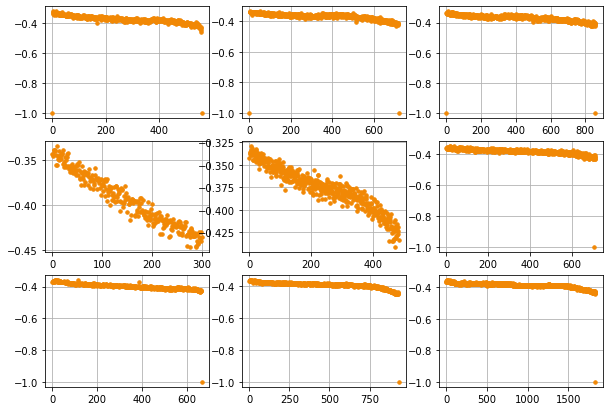

In [174]:
fig, axes = plt.subplots(nrows =3, ncols =3, figsize= (10,7))
for i in range(3):
    for j in range(3):
        axes[i,j].scatter(np.arange(y[idxs[i,j]]), overpot_discharge[idxs[i,j], :y[idxs[i,j]]] ,label = labels[i], s=font_xsmall)
#         axes[i,j].set_ylim(-.5, -.3)
#         axes[1].scatter(np.arange(y[idxs[i,j]]), overpot_discharge[idxs[i,j], :y[idxs[i,j]]] ,label = labels[i], s=font_xsmall)

In [176]:
overpot_discharge[idxs[i,j]]

array([-0.36818212, -0.36257944, -0.36539313, ..., -1.        ,
       -1.        , -1.        ])

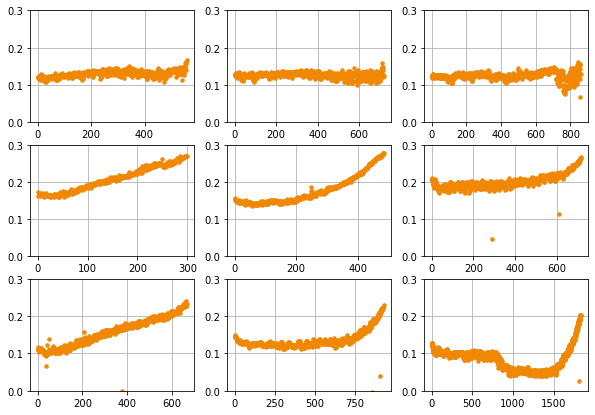

In [133]:
fig, axes = plt.subplots(nrows =3, ncols =3, figsize= (10,7))
for i in range(3):
    for j in range(3):
        axes[i,j].scatter(np.arange(y[idxs[i,j]]), overpot_charge[idxs[i,j], :y[idxs[i,j]]] ,label = labels[i], s=font_xsmall)
        axes[i,j].set_ylim(.0, .3)
#         axes[1].scatter(np.arange(y[idxs[i,j]]), overpot_discharge[idxs[i,j], :y[idxs[i,j]]] ,label = labels[i], s=font_xsmall)

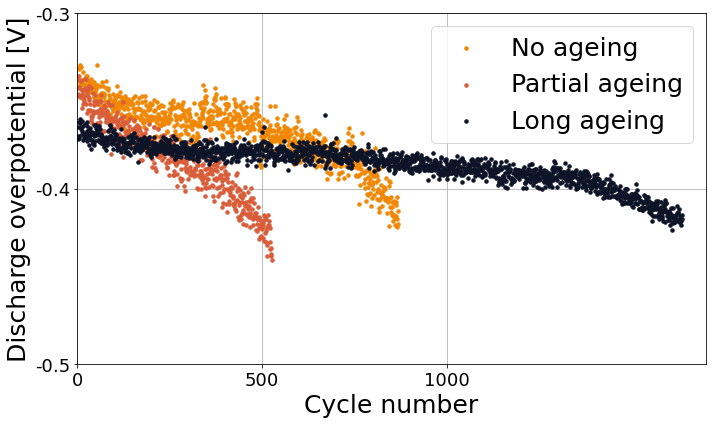

In [173]:
ids = [21,59,99]
labels = ["No ageing", "Partial ageing", "Long ageing"]
title = "Overpotential"


fig, axes = plt.subplots(nrows =1, figsize= (10,6))
# fig.suptitle(title, fontsize = font_large)
for i in range(3):
#     axes[0].scatter(np.arange(y[ids[i]]), overpot_charge[ids[i], :y[ids[i]]] ,label = labels[i], s=font_xsmall)
    axes.scatter(np.arange(y[ids[i]]), overpot_discharge[ids[i], :y[ids[i]]] ,label = labels[i], s=font_xsmall)


axes.set_ylim(-.5, -.3)

axes.set_xlim(.0, 1700)
axes.set_title('',fontsize = font_medium)

axes.set_xticks([500*x for x in range(3)],[500*x for x in range(3)],fontsize = font_small)

axes.set_yticks([-.3 - .1*x for x in range(3)],[-.3 - .1*x for x in range(3)],fontsize = font_small)




plt.xlabel("Cycle number", fontsize = font_medium)
axes.set_ylabel('Discharge overpotential [V]', fontsize = font_medium)
# axes.yaxis.set_label_coords(-0.07,-.2)
axes.legend(loc=1, prop={'size': font_medium});
plt.tight_layout()
plt.savefig(oj(result_path,"Fig1_img.png"))

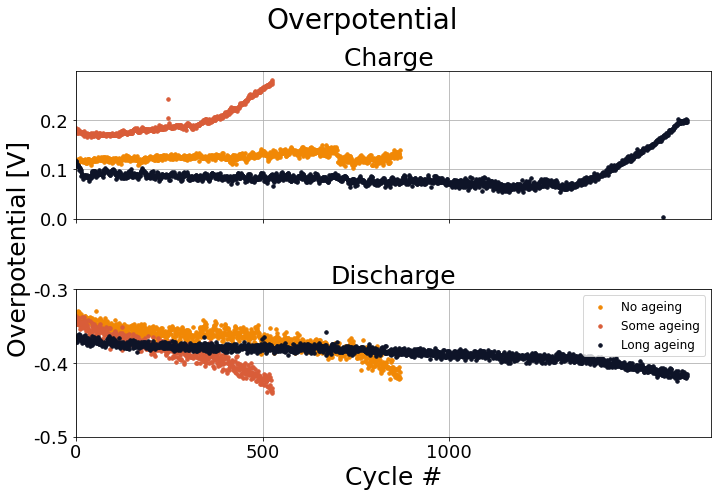

In [10]:
ids = [21,59,99]
labels = ["No ageing", "Some ageing", "Long ageing"]
title = "Overpotential"


fig, axes = plt.subplots(nrows =2, figsize= (10,7))
fig.suptitle(title, fontsize = font_large)
for i in range(3):
    axes[0].scatter(np.arange(y[ids[i]]), overpot_charge[ids[i], :y[ids[i]]] ,label = labels[i], s=font_xsmall)
    axes[1].scatter(np.arange(y[ids[i]]), overpot_discharge[ids[i], :y[ids[i]]] ,label = labels[i], s=font_xsmall)

axes[0].set_ylim(.0, .3)
axes[1].set_ylim(-.5, -.3)

axes[0].set_xlim(.0, 1700)
axes[1].set_xlim(.0, 1700)

axes[0].set_title('Charge ',fontsize = font_medium)
axes[1].set_title('Discharge',fontsize = font_medium)

axes[0].set_ylim(.0, .3)
axes[0].set_xticks([500*x for x in range(3)],[],fontsize = font_small)
axes[1].set_xticks([500*x for x in range(3)],[500*x for x in range(3)],fontsize = font_small)

axes[0].set_yticks([.1*x for x in range(3)],[.1*x for x in range(3)],fontsize = font_small)
axes[1].set_yticks([-.3 - .1*x for x in range(3)],[-.3 - .1*x for x in range(3)],fontsize = font_small)




plt.xlabel("Cycle #", fontsize = font_medium)
axes[0].set_ylabel('Overpotential [V]', fontsize = font_medium)
axes[0].yaxis.set_label_coords(-0.07,-.2)
axes[1].legend(loc=1, prop={'size': font_xsmall});
plt.tight_layout()
plt.savefig(oj(result_path,"BatchComparison.png"))

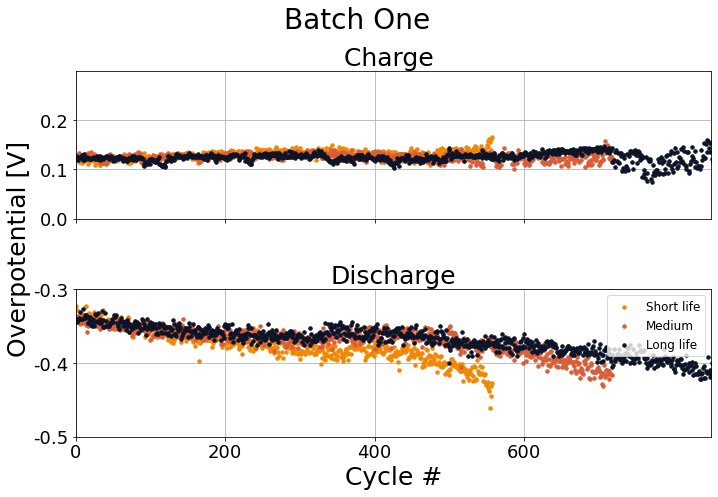

In [31]:
ids = [17,11,23]
labels = ["Short life", "Medium", "Long life"]
title = "Batch One "
y_lim = 850
fig, axes = plt.subplots(nrows =2, figsize= (10,7))
fig.suptitle(title, fontsize = font_large)

for i in range(3):
    axes[0].scatter(np.arange(y[ids[i]]), overpot_charge[ids[i], :y[ids[i]]] ,label = labels[i], s=font_xsmall)
    axes[1].scatter(np.arange(y[ids[i]]), overpot_discharge[ids[i], :y[ids[i]]] ,label = labels[i], s=font_xsmall)

axes[0].set_ylim(.0, .3)
axes[1].set_ylim(-.5, -.3)

axes[0].set_xlim(.0, y_lim)
axes[1].set_xlim(.0, y_lim)

axes[0].set_title('Charge ',fontsize = font_medium)
axes[1].set_title('Discharge',fontsize = font_medium)

axes[0].set_xticks([200*x for x in range(4)],[],fontsize = font_small)
axes[1].set_xticks([200*x for x in range(4)],[200*x for x in range(4)],fontsize = font_small)

axes[0].set_yticks([.1*x for x in range(3)],[.1*x for x in range(3)],fontsize = font_small)
axes[1].set_yticks([-.3 - .1*x for x in range(3)],[-.3 - .1*x for x in range(3)],fontsize = font_small)


axes[1].legend(loc=1, prop={'size': font_xsmall});

plt.xlabel("Cycle #", fontsize = font_medium)
axes[0].set_ylabel('Overpotential [V]', fontsize = font_medium)
axes[0].yaxis.set_label_coords(-0.07,-.2)

plt.tight_layout()
plt.savefig(oj(result_path,"BatchOneComparison.png"))

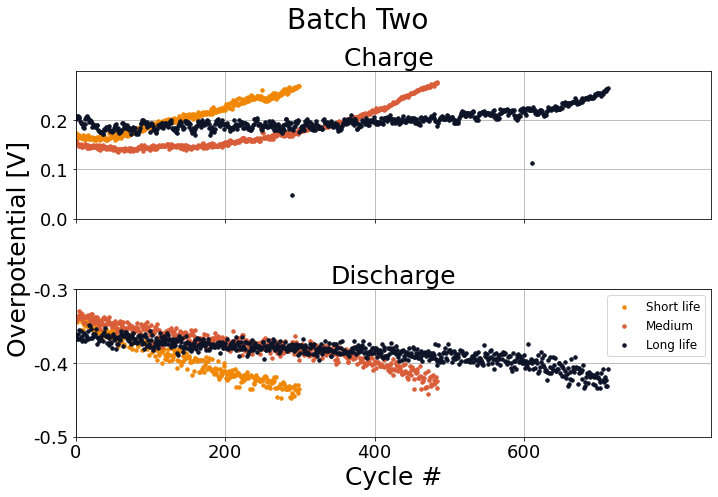

In [32]:
ids = [41,52,83]
labels = ["Short life", "Medium", "Long life"]
title = "Batch Two "
y_lim = 850
fig, axes = plt.subplots(nrows =2, figsize= (10,7))
fig.suptitle(title, fontsize = font_large)

for i in range(3):
    axes[0].scatter(np.arange(y[ids[i]]), overpot_charge[ids[i], :y[ids[i]]] ,label = labels[i], s=font_xsmall)
    axes[1].scatter(np.arange(y[ids[i]]), overpot_discharge[ids[i], :y[ids[i]]] ,label = labels[i], s=font_xsmall)

axes[0].set_ylim(.0, .3)
axes[1].set_ylim(-.5, -.3)

axes[0].set_xlim(.0, y_lim)
axes[1].set_xlim(.0, y_lim)

axes[0].set_title('Charge ',fontsize = font_medium)
axes[1].set_title('Discharge',fontsize = font_medium)

axes[0].set_xticks([200*x for x in range(4)],[],fontsize = font_small)
axes[1].set_xticks([200*x for x in range(4)],[200*x for x in range(4)],fontsize = font_small)

axes[0].set_yticks([.1*x for x in range(3)],[.1*x for x in range(3)],fontsize = font_small)
axes[1].set_yticks([-.3 - .1*x for x in range(3)],[-.3 - .1*x for x in range(3)],fontsize = font_small)




plt.xlabel("Cycle #", fontsize = font_medium)
axes[0].set_ylabel('Overpotential [V]', fontsize = font_medium)
axes[0].yaxis.set_label_coords(-0.07,-.2)
axes[1].legend(loc=1, prop={'size': font_xsmall});
plt.tight_layout()
plt.savefig(oj(result_path,"BatchTwoComparison.png"))

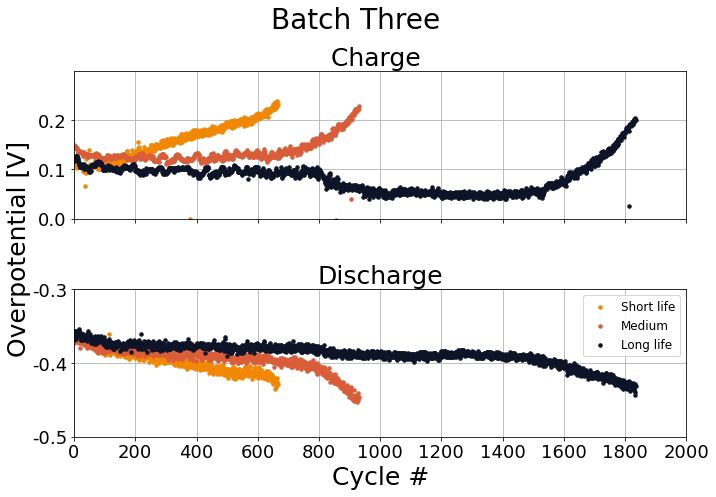

In [33]:
ids = [89,95,90]


labels = ["Short life", "Medium", "Long life"]
title = "Batch Three "
y_lim = 2000
fig, axes = plt.subplots(nrows =2, figsize= (10,7))
fig.suptitle(title, fontsize = font_large)

for i in range(3):
    axes[0].scatter(np.arange(y[ids[i]]), overpot_charge[ids[i], :y[ids[i]]] ,label = labels[i], s=font_xsmall)
    axes[1].scatter(np.arange(y[ids[i]]), overpot_discharge[ids[i], :y[ids[i]]] ,label = labels[i], s=font_xsmall)

axes[0].set_ylim(.0, .3)
axes[1].set_ylim(-.5, -.3)



axes[0].set_title('Charge ',fontsize = font_medium)
axes[1].set_title('Discharge',fontsize = font_medium)

axes[0].set_xticks([200*x for x in range(15)],[],fontsize = font_small)
axes[1].set_xticks([200*x for x in range(15)],[200*x for x in range(15)],fontsize = font_small)

axes[0].set_yticks([.1*x for x in range(3)],[.1*x for x in range(3)],fontsize = font_small)
axes[1].set_yticks([-.3 - .1*x for x in range(3)],[-.3 - .1*x for x in range(3)],fontsize = font_small)

axes[0].set_xlim(.0, y_lim)
axes[1].set_xlim(.0, y_lim)


plt.xlabel("Cycle #", fontsize = font_medium)
axes[0].set_ylabel('Overpotential [V]', fontsize = font_medium)
axes[0].yaxis.set_label_coords(-0.07,-.2)
axes[1].legend(loc=1, prop={'size': font_xsmall});
plt.tight_layout()
plt.savefig(oj(result_path,"BatchThreeComparison.png"))

In [23]:
lengths =[41,43+41,124]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


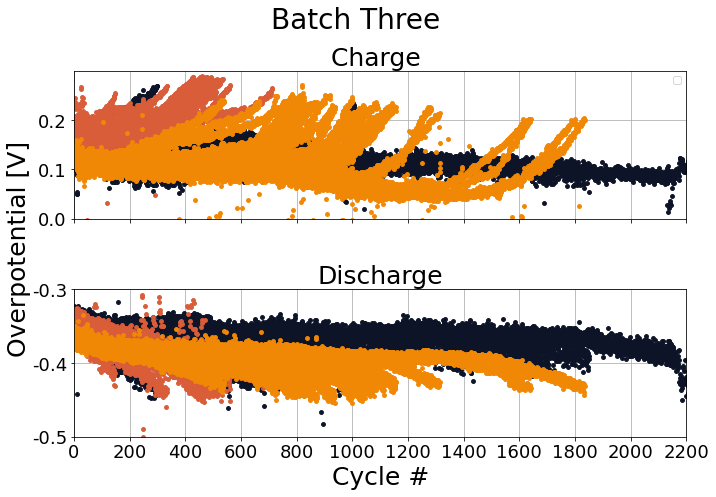

In [24]:
ids = [x for x in range(124)]


labels = ["Short life", "Medium", "Long life"]
title = "Batch Three "
y_lim = 2200
fig, axes = plt.subplots(nrows =2, figsize= (10,7))
fig.suptitle(title, fontsize = font_large)

for i in range(124):
    
    if i >lengths[1]:
        col = colours[0]
        
    elif i <lengths[1] and i > lengths[0]:
        col = colours[1]
    else:
        col = colours[2]
        

    axes[0].scatter(np.arange(y[i]), overpot_charge[i, :y[i]] ,c=col, s=font_xsmall)
    axes[1].scatter(np.arange(y[i]), overpot_discharge[i, :y[i]] ,c=col, s=font_xsmall)

axes[0].set_ylim(.0, .3)
axes[1].set_ylim(-.5, -.3)



axes[0].set_title('Charge ',fontsize = font_medium)
axes[1].set_title('Discharge',fontsize = font_medium)

axes[0].set_xticks([200*x for x in range(15)],[],fontsize = font_small)
axes[1].set_xticks([200*x for x in range(15)],[200*x for x in range(15)],fontsize = font_small)

axes[0].set_yticks([.1*x for x in range(3)],[.1*x for x in range(3)],fontsize = font_small)
axes[1].set_yticks([-.3 - .1*x for x in range(3)],[-.3 - .1*x for x in range(3)],fontsize = font_small)

axes[0].set_xlim(.0, y_lim)
axes[1].set_xlim(.0, y_lim)


plt.xlabel("Cycle #", fontsize = font_medium)
axes[0].set_ylabel('Overpotential [V]', fontsize = font_medium)
axes[0].yaxis.set_label_coords(-0.07,-.2)
axes[0].legend();
plt.tight_layout()
plt.savefig(oj(result_path,"AllComparisons.png"))

In [237]:
y[:43].mean()

888.9069767441861

In [238]:
y[41:41+43].mean()

473.2093023255814